<a href="https://colab.research.google.com/github/Mel0307822/moviedata/blob/main/movie_magic_data_driven_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:180%; font-family:Arial, sans-serif; background-color:#560c10; color:#DCD2C9; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> Análisis de preferencia de espectadores y factores de éxito comercial de películas </b></div>

![movie](https://i.postimg.cc/qMKfD6sK/flat-design-movie-theater-background-23-2150998492.jpg)

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:60%; font-family:Arial, sans-serif; background-color:#083307; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b>1. Importar librerias necesarias </b></div>

In [70]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split

import ast
import warnings

from keras.models import Sequential
from keras.layers import Dense

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Eliminar alertas (warnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:60%; font-family:Arial, sans-serif; background-color:#083307; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 2. Limpieza de datos
 </b></div>

- **Paso 1: Lectura de datos.** Comencemos leyendo el archivo CSV que contiene los metadatos de las películas (movie_metadata.csv)

- **Paso 2: Selección de columnas relevantes**. Conservaremos sólo las columnas esenciales para nuestro modelo de recomendación, como ID, título de la película, género, palabras clave del argumento, nombre del director, ingreso bruto, puntuación imdb, etc.

- **Paso 3: Limpiar los datos de las películas.** Las filas con valores perdidos en la columna id se eliminan para garantizar un conjunto de datos limpio.


In [ ]:
# Lectura de documento CSV
movies_df = pd.read_csv('movie_metadata.csv')
movies_df.head(20)

In [ ]:
# Verificar el resumen estadístico del dataset
movies_df.describe()

# Verificar los tipos de datos y si hay valores nulos
movies_df.info()

In [ ]:
# Verificar valores nulos
movies_df.isnull().sum()

In [ ]:
# Selección de columnas relevantes para el modelo
relevant_data = movies_df[['movie_title',
    'genero',
    'duration',
    'num_critic_for_reviews',
    'director_facebook_likes',
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'cast_total_facebook_likes',
    'num_voted_users',
    'gross',
    'imdb_score',
    'budget',
    'movie_facebook_likes']]

relevant_data.isnull().sum()

In [ ]:
relevant_data.dropna(inplace=True)

Verificación

In [ ]:
relevant_data.count()

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:60%; font-family:Arial, sans-serif; background-color:#083307; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 3. Preprocesamiento de datos e ingeniería de características </b></div>

-  **Paso 4: Procesamiento de géneros**. Los datos de género se almacenan inicialmente como un objeto. Primero, rellenaremos los datos de género que falten con listas vacías. Después, usando el método split de Python, convertiremos estas representaciones de cadena en listas reales de Python.

-  **Paso 5: Extraer los nombres de los géneros**. De la lista de diccionarios, extraigamos los nombres de los géneros y almacenémoslos en una nueva columna llamada genre_names. Esto hace que los datos de género sean más accesibles para su posterior procesamiento.

-  **Paso 6: Codificación de géneros**. Dado que la información de género es categórica, realizaremos una codificación en caliente para convertir los nombres de género en columnas binarias. Este paso nos permite utilizar los géneros como características de entrada para nuestro modelo de recomendación.

-  **Paso 7: Eliminación de columnas innecesarias**. Tras la codificación de una sola vez, las columnas originales genres y genre_names ya no son necesarias, por lo que se eliminan del conjunto de datos.


In [ ]:
# Procesamiento de géneros
# Llenar las filas de género vacías con listas vacías
relevant_data['genero'] = relevant_data['genero'].fillna('[]')

relevant_data['genero'] = relevant_data['genero'].apply(lambda x: x.split('|'))

relevant_data['genero'].head()

In [ ]:
# Copiar la información en nueva columna para evitar la sustitución de la información
relevant_data['genre_names'] = relevant_data['genero']

In [ ]:
# One-hot encoding para la codificaciones de géneros
# convertir los valores de Género a binarios para tomar estos valores como entradas de la red neuronal
genre_dummies = relevant_data['genre_names'].str.join('|').str.get_dummies()
print(genre_dummies)

In [ ]:
# Concatenar los dummies con el dataframe original
relevant_data = pd.concat([relevant_data, genre_dummies], axis=1)

In [ ]:
# Eliminación de las columnas genero y genre-names que ya fueron binarizadas
relevant_data.drop(['genero','genre_names'],axis=1, inplace=True)
relevant_data.info()

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:60%; font-family:Arial, sans-serif; background-color:#083307; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 4. Exploratory Data Analysis </b></div>

## <div style="text-align:left; border-radius:10px; padding:10px; margin:5px 0; font-size:50%; font-family:Arial, sans-serif; background-color:#f2f2f2; color:#145214; overflow:hidden; box-shadow:0 2px 4px rgba(0, 0, 0, 0.1);"><b>4.1. Distribución de Peliculas basadas en su Genero</b></div>



In [ ]:
# Conteo de películas por género
genre_counts = genre_dummies.sum().sort_values(ascending=False)

# Configuración de la figura
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")

# Graficación de la distribución de géneros
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title('Distribución de Películas por Género', fontsize=16, fontweight='bold')
plt.xlabel('Número de Películas', fontsize=14)
plt.ylabel('Géneros', fontsize=14)

# Ajuste de los textos en los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


La gráfica confirma que géneros como drama y comedia dominan la producción cinematográfica, mientras que los géneros más especializados o clásicos (por ejemplo, Film-Noir o Western) tienen menor representación. Esto podría estar influenciado tanto por las preferencias del público como por las estrategias de mercado en la industria del cine.

## <div style="text-align:left; border-radius:10px; padding:10px; margin:5px 0; font-size:50%; font-family:Arial, sans-serif; background-color:#f2f2f2; color:#145214; overflow:hidden; box-shadow:0 2px 4px rgba(0, 0, 0, 0.1);"><b>4.2. Ingresos por género</b></div>



In [ ]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos las columnas numéricas
numeric_columns = ['duration',
    'num_critic_for_reviews',
    'director_facebook_likes',
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'cast_total_facebook_likes',
    'num_voted_users',
    'gross',
    'budget',
    'movie_facebook_likes']

# Aplicamos la normalización usando StandardScaler
scaler = StandardScaler()
relevant_data[numeric_columns] = scaler.fit_transform(relevant_data[numeric_columns])

# Verificamos cómo queda el DataFrame después de la normalización
relevant_data[numeric_columns].head()


In [ ]:
# Sumar el 'gross' para cada género
genre_gross_sum = (relevant_data[genre_dummies.columns] * relevant_data['gross'].values[:, None]).sum().sort_values(ascending=False)

# Configuración de la figura
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")

# Graficar la suma de ingresos por género
sns.barplot(x=genre_gross_sum.values, y=genre_gross_sum.index, palette="crest")
plt.title('Suma de Ingresos por Género de Películas', fontsize=16, fontweight='bold')
plt.xlabel('Ingresos Totales (en dólares)', fontsize=14)
plt.ylabel('Géneros', fontsize=14)

# Formatear valores en el eje x (opcional: si los números son grandes)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Ajustar la presentación
plt.tight_layout()
plt.show()



Las películas de acción, comedia, drama y aventura son las que generan más ingresos.

## <div style="text-align:left; border-radius:10px; padding:10px; margin:5px 0; font-size:50%; font-family:Arial, sans-serif; background-color:#f2f2f2; color:#145214; overflow:hidden; box-shadow:0 2px 4px rgba(0, 0, 0, 0.1);"><b>4.3. Distribución de Puntuación de IMDB</b></div>



In [ ]:
# Gráfico de la distribución de puntuaciones de IMDb
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Histograma de puntuaciones de IMDb
sns.histplot(
    relevant_data['imdb_score'], 
    bins=15,  # Más bins para una mayor precisión en la distribución
    kde=True,  # Se agrega KDE para visualizar mejor la densidad
    color="teal",  # Color profesional y accesible
    edgecolor="black"  # Bordes en las barras para mejor definición
)

# Título y etiquetas de los ejes
plt.title('Distribución de Puntajes IMDb', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Puntajes IMDb', fontsize=14, labelpad=10)
plt.ylabel('Conteo', fontsize=14, labelpad=10)

# Ajuste de las etiquetas del eje
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Líneas de referencia
plt.axvline(relevant_data['imdb_score'].mean(), color='red', linestyle='--', linewidth=1.5, label=f'Media: {relevant_data["imdb_score"].mean():.2f}')
plt.axvline(relevant_data['imdb_score'].median(), color='blue', linestyle='--', linewidth=1.5, label=f'Mediana: {relevant_data["imdb_score"].median():.2f}')

# Leyenda
plt.legend(fontsize=12, loc='upper left')

# Ajustar la presentación
plt.tight_layout()
plt.show()

El gráfico muestra que los puntajes IMDb analizados tienen una distribución centrada alrededor de 6.5, con una forma simétrica similar a una campana, lo que sugiere que la mayoría de las películas o series están calificadas en un rango medio. La media es de 6.46 y la mediana de 6.60, lo que indica que los datos están ligeramente sesgados hacia la izquierda, pero la diferencia es mínima, reflejando una distribución casi equilibrada.

En general, la mayoría de las producciones tienen puntajes cercanos al promedio, mientras que los valores extremadamente bajos o altos son menos comunes. Esto sugiere que la mayoría de los usuarios evalúan las películas o series dentro de un rango moderado, con pocas producciones destacando como excepcionales o muy malas.

## <div style="text-align:left; border-radius:10px; padding:10px; margin:5px 0; font-size:50%; font-family:Arial, sans-serif; background-color:#f2f2f2; color:#145214; overflow:hidden; box-shadow:0 2px 4px rgba(0, 0, 0, 0.1);"><b>4.4. Mapa de correlación entre las variables seleccionadas</b></div>



In [ ]:
# Seleccionar solo las columnas numéricas del DataFrame
datos = relevant_data[[
    'duration',
    'num_critic_for_reviews',
    'director_facebook_likes',
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'cast_total_facebook_likes',
    'num_voted_users',
    'gross',
    'imdb_score',
    'budget',
    'movie_facebook_likes']]

# Calcular la matriz de correlación
correlation_matrix = datos.corr()

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Heatmap con ajustes estilísticos
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5,  # Líneas entre celdas para mayor claridad
    cbar_kws={"shrink": 0.8, "label": "Nivel de correlación"}  # Personalización de la barra de color
)

# Título y configuración del gráfico
plt.title('Matriz de Correlación entre las Variables Numéricas', fontsize=18, fontweight='bold', pad=15)
plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotar etiquetas para mejor visualización
plt.yticks(fontsize=12, rotation=0)

# Ajustar la presentación
plt.tight_layout()
plt.show()

La matriz de correlación muestra que las me gusta de los actores principales están fuertemente relacionadas con el total del reparto (0.95). También, las películas con más críticas (num_critic_for_reviews) tienden a ser más populares en redes sociales (movie_facebook_likes) con una correlación de 0.70.

Además, variables como num_voted_users y gross (0.63) sugieren que más votos se asocian con mayores ingresos. Por otro lado, métricas como el presupuesto (budget) tienen correlaciones débiles con el desempeño general, destacando la influencia mayor de las redes sociales y críticas en el éxito de las películas.

## <div style="text-align:left; border-radius:10px; padding:10px; margin:5px 0; font-size:50%; font-family:Arial, sans-serif; background-color:#f2f2f2; color:#145214; overflow:hidden; box-shadow:0 2px 4px rgba(0, 0, 0, 0.1);"><b>4.5. Presupuesto y ganancias</b></div>



In [ ]:
# Crear la gráfica de dispersión mejorada
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Gráfico de dispersión
sns.scatterplot(
    x=relevant_data['budget'], 
    y=relevant_data['gross'], 
    color='teal', 
    alpha=0.7, 
    edgecolor='black'
)

# Título y etiquetas de los ejes
plt.title('Relación entre Presupuesto y Ganancias', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Presupuesto (USD)', fontsize=14, labelpad=10)
plt.ylabel('Ganancias (USD)', fontsize=14, labelpad=10)

# Ajuste de etiquetas en los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Líneas de referencia (media)
plt.axhline(relevant_data['gross'].mean(), color='red', linestyle='--', linewidth=1.5, label=f'Media Ganancias: {relevant_data["gross"].mean():,.0f}')
plt.axvline(relevant_data['budget'].mean(), color='blue', linestyle='--', linewidth=1.5, label=f'Media Presupuesto: {relevant_data["budget"].mean():,.0f}')

# Leyenda
plt.legend(fontsize=12, loc='upper left', frameon=True)

# Ajustar diseño
plt.tight_layout()
plt.show()



El gráfico muestra la relación entre el presupuesto y las ganancias de las películas. La mayoría de las producciones tienen presupuestos bajos, con una concentración cerca de la mediana de 45,284,681 USD (línea azul discontinua). Las ganancias también están agrupadas en valores bajos, con una media de 51,186,792 USD (línea roja discontinua), aunque se observan algunos puntos extremos con ganancias y presupuestos muy altos.

En general, no parece haber una relación clara y proporcional entre presupuesto y ganancias, ya que muchas películas con presupuestos bajos logran ganancias similares a aquellas con presupuestos más altos. Los valores extremos en ambos ejes sugieren que solo unas pocas producciones escapan a esta tendencia, generando ingresos significativamente mayores.

## <div style="text-align:left; border-radius:10px; padding:10px; margin:5px 0; font-size:50%; font-family:Arial, sans-serif; background-color:#f2f2f2; color:#145214; overflow:hidden; box-shadow:0 2px 4px rgba(0, 0, 0, 0.1);"><b>4.6. Mejores puntajes IMDB</b></div>



In [ ]:
# Ordenar las películas por IMDb score
top_30_movies_sorted = relevant_data.sort_values(by='imdb_score', ascending=False).head(30)

# Crear la gráfica mejorada
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Gráfico de barras
sns.barplot(
    x='movie_title', 
    y='imdb_score', 
    data=top_30_movies_sorted, 
    palette='magma'
)

# Añadir título y etiquetas
plt.title('Top 30 Películas con Mejores Puntajes IMDb', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Película', fontsize=14, labelpad=10)
plt.ylabel('Puntaje IMDb', fontsize=14, labelpad=10)

# Rotación y ajuste de etiquetas del eje X
plt.xticks(rotation=45, ha='right', fontsize=12)

# Añadir líneas de referencia para mejorar visualización
plt.axhline(9, color='green', linestyle='--', linewidth=1.5, label='Excelente (>= 9)')
plt.axhline(8, color='orange', linestyle='--', linewidth=1.5, label='Muy bueno (>= 8)')

# Leyenda
plt.legend(fontsize=12, loc='upper right', frameon=True)

# Ajustar diseño
plt.tight_layout()
plt.show()


Este gráfico muestra el Top 30 de películas con mejores puntajes IMDb, organizadas por su calificación. Todas las películas en este grupo tienen puntajes superiores a 8, destacando la excelencia en la percepción del público según IMDb. Las películas con calificaciones iguales o mayores a 9 (zona marcada como "Excelente" con una línea verde) son especialmente notables, lideradas por títulos como The Shawshank Redemption y The Godfather.

El resto de las películas tienen puntajes entre 8 y 9, consideradas como "Muy buenas" (zona delimitada por la línea naranja). Esto refleja que el Top 30 está compuesto por obras cinematográficas de gran calidad y relevancia cultural, siendo clásicos y favoritas del público. La distribución muestra una ligera variación entre estas películas, pero todas son consistentemente bien valoradas.

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:60%; font-family:Arial, sans-serif; background-color:#083307; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 5. Preparacion de los Datos para el modelo </b></div>

- **Paso 8: Preprocesamiento para la entrada del modelo**. Nos aseguraremos de que las variables de entrada tengan el correcto formato. se aplicaran one hot encoding y standar scaler para el proceso.

In [78]:
from sklearn.preprocessing import StandardScaler

# Definimos las columnas numéricas que serán normalizadas
numeric_columns = [
    'duration',
    'num_critic_for_reviews',
    'director_facebook_likes',
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'cast_total_facebook_likes',
    'num_voted_users',
    'gross',
    'budget',
    'movie_facebook_likes'
]

# Validamos que las columnas numéricas existan en el DataFrame
missing_columns = [col for col in numeric_columns if col not in relevant_data.columns]
if missing_columns:
    raise ValueError(f"Las siguientes columnas están ausentes en el DataFrame: {missing_columns}")

# Normalizamos las columnas seleccionadas utilizando StandardScaler
scaler = StandardScaler()
relevant_data[numeric_columns] = scaler.fit_transform(relevant_data[numeric_columns])

# Mostramos una vista previa del DataFrame después de la normalización
relevant_data[numeric_columns].head()


,duration,num_critic_for_reviews,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,num_voted_users,gross,budget,movie_facebook_likes
0,2.999943,4.512030,-0.259274,-0.429092,-0.231302,0.054153,-0.341032,5.193151,10.154671,0.860923,1.117825
1,2.603157,1.116867,-0.072954,2.107003,0.674137,0.131826,1.956191,2.442030,3.696661,1.143832,-0.429453
2,1.677321,3.536223,-0.259274,0.221189,-0.352280,-0.317606,0.021426,1.146951,2.131484,0.896848,3.555961
3,2.382720,5.237837,7.021439,1.261638,4.684448,11.916692,5.039619,6.904435,5.682681,0.919301,7.260052
4,0.971923,2.407190,-0.102077,-0.452502,-0.299032,-0.119941,-0.497344,0.724893,0.313120,0.980822,0.695840


In [79]:
relevant_data.to_csv('relevant_data.csv', index=False)

Leer datos preparados

In [80]:
relevant_data = pd.read_csv('relevant_data.csv')
relevant_data.head()

,movie_title,duration,num_critic_for_reviews,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,num_voted_users,gross,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Avatar,2.999943,4.512030,-0.259274,-0.429092,-0.231302,0.054153,-0.341032,5.193151,10.154671,...,0,0,0,0,1,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,2.603157,1.116867,-0.072954,2.107003,0.674137,0.131826,1.956191,2.442030,3.696661,...,0,0,0,0,0,0,0,0,0,0
2,Spectre,1.677321,3.536223,-0.259274,0.221189,-0.352280,-0.317606,0.021426,1.146951,2.131484,...,0,0,0,0,0,0,0,1,0,0
3,The Dark Knight Rises,2.382720,5.237837,7.021439,1.261638,4.684448,11.916692,5.039619,6.904435,5.682681,...,0,0,0,0,0,0,0,1,0,0
4,John Carter,0.971923,2.407190,-0.102077,-0.452502,-0.299032,-0.119941,-0.497344,0.724893,0.313120,...,0,0,0,0,1,0,0,0,0,0


<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:150%; font-family:Arial, sans-serif; background-color:#083307; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);">
    <b>6. Sistema de Recomendación</b>
</div>

c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.2969 - mae: 4.2552 - val_loss: 3.8152 - val_mae: 1.2701
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5034 - mae: 1.1202 - val_loss: 2.3686 - val_mae: 1.0856
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 1.7854 - mae: 1.0075 - val_loss: 1.8039 - val_mae: 0.9716
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 1.3304 - mae: 0.8768 - val_loss: 1.4700 - val_mae: 0.8575
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 1.0766 - mae: 0.7924 - val_loss: 1.2420 - val_mae: 0.7741
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.8370 - mae: 0.7025 - val_loss: 1.0933 - val_mae: 0.7125
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.7706 - mae: 0.6616 - val_loss: 1.0881 - val_mae: 0.6665
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6635 - mae: 0.6103 - val_loss: 1.0393 - val_mae: 0.6269
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0

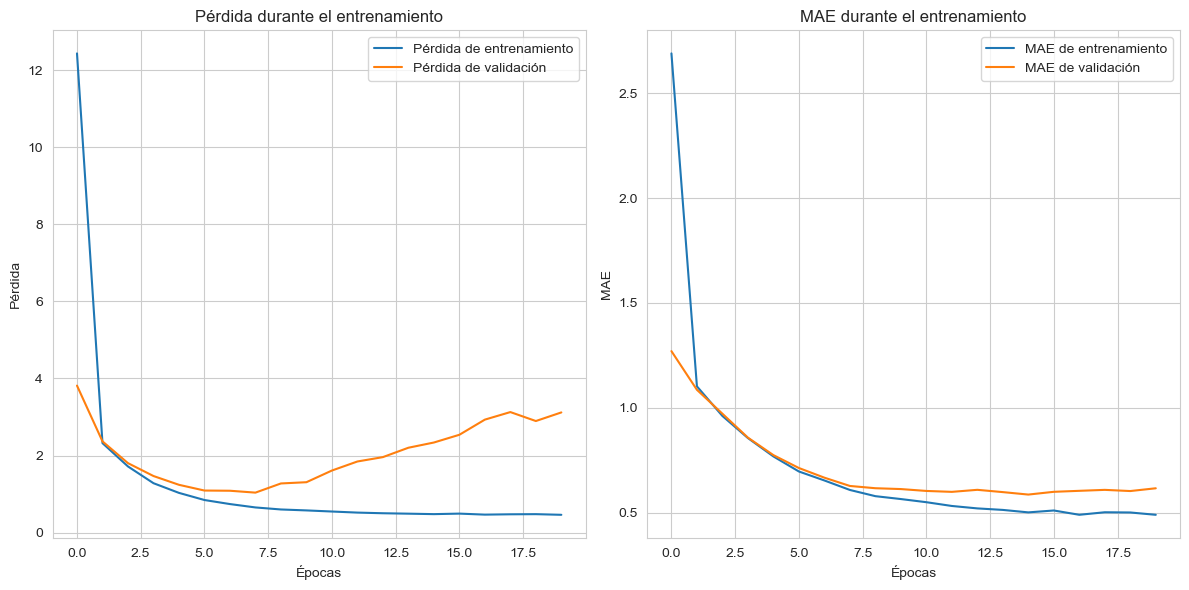

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 5.1712 - mae: 0.6658
Pérdida del modelo (MSE): 3.1198208332061768
Error absoluto medio (MAE): 0.6158722043037415


In [81]:
# Separación de X y Y
X = relevant_data.drop(columns=['imdb_score', 'movie_title'])
Y = relevant_data['imdb_score']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Construcción del modelo de red neuronal
model = Sequential()

# Capa de entrada
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))  # 128 neuronas en la primera capa

# Capa oculta
model.add(Dense(64, activation='relu'))  # 64 neuronas en la segunda capa

# Capa de salida sin función de activación, para permitir predicciones en el rango de 1 a 10
model.add(Dense(1))  # Salida única, sin activación

# Compilación del modelo con un optimizador ajustado y métricas adicionales
optimizer = Adam(learning_rate=0.001)  # Ajuste de la tasa de aprendizaje
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
model.summary()

# Entrenamiento del modelo y guardar el historial
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

# Graficar la pérdida (loss) durante el entrenamiento
plt.figure(figsize=(12, 6))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Error absoluto medio (MAE) de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de validación')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Evaluar el modelo
loss, mae = model.evaluate(X_test, Y_test)
print(f'Pérdida del modelo (MSE): {loss}')
print(f'Error absoluto medio (MAE): {mae}')

In [82]:
# Hacer predicciones con el modelo entrenado
predictions = model.predict(X_test)

# Escalar las predicciones para asegurarnos de que estén entre 1 y 10
# Dado que el rango real de imdb_score es [1, 10], necesitamos hacer un escalado
predictions = np.clip(predictions, 1, 10)  # Limitar las predicciones a un rango de 1 a 10

# Mostrar algunas predicciones junto con los valores reales
for i in range(100):
    print(f"Real: {Y_test.iloc[i]}, Predicción: {predictions[i][0]}")

# Función para predecir la similitud de una película con las demás usando la red neuronal
def predict_similarity_nn(df):
    """
    Predice la similitud entre todas las películas utilizando la red neuronal.
    """
    # Realizamos predicciones para todas las películas
    predictions = model.predict(X)  # Usar X original para todas las películas

    # Limitar las predicciones a un rango de 1 a 10
    predictions = np.clip(predictions, 1, 10)  # Escalar a [1, 10]

    # Crear un DataFrame con las predicciones y las películas
    pred_df = pd.DataFrame(predictions, columns=['predicted_imdb_score'], index=df['movie_title'])

    # Ordenar las películas por la predicción de mayor a menor
    pred_df = pred_df.sort_values(by='predicted_imdb_score', ascending=False)

    return pred_df

# Función para obtener el vector de características de una película por título
def get_movie_vector(title, df):
    """
    Obtiene el vector de características para una película dada su título.
    """
    movie_data = df[df['movie_title'].str.contains(title, case=False, na=False)]  # Filtrar por título

    if not movie_data.empty:
        return movie_data.drop(columns=['movie_title', 'imdb_score']).values[0]  # Devolver el vector
    else:
        print(f"Película con el título que contiene '{title}' no encontrada.")
        return None

# Función para recomendar películas basadas en la similitud con la red neuronal
def recommend_movie_by_title_and_features_nn(query_title, df, top_n=5):
    """
    Recomendación basada en la similitud con una película dada por su título y sus características.
    """
    query_vector = get_movie_vector(query_title, df)

    if query_vector is not None:
        # Predicción de todas las películas
        pred_df = predict_similarity_nn(df)

        # Obtener el top_n de películas más similares
        top_similar_movies_by_features = pred_df.head(top_n + 1)  # Top n+1 porque incluye la película de consulta
        top_similar_movies_by_features = top_similar_movies_by_features.iloc[1:]  # Excluir la propia película

        return top_similar_movies_by_features
    else:
        return None

# Función principal para combinar las recomendaciones con la red neuronal
def recommend_movies_with_nn(query, df, top_n=5):
    """
    Recomienda películas basadas en el título y sus características utilizando redes neuronales.
    """
    preprocessed_query = preprocess_input(query)

    # Recomendaciones basadas en el título
    print(f"\nRecomendaciones basadas en el título '{preprocessed_query}':")
    similar_by_title = df[df['movie_title'].str.contains(preprocessed_query, case=False, na=False)]
    if not similar_by_title.empty:
        print(similar_by_title[['movie_title', 'gross', 'imdb_score']])
    else:
        print(f"No se encontraron películas con el título '{preprocessed_query}'.")

    # Recomendaciones basadas en las características utilizando la red neuronal
    print(f"\nRecomendaciones basadas en las características de la película '{preprocessed_query}':")
    top_similar_movies_by_features = recommend_movie_by_title_and_features_nn(preprocessed_query, df, top_n=top_n)
    if top_similar_movies_by_features is not None:
        print(top_similar_movies_by_features)
    else:
        print(f"No se pudo obtener recomendaciones basadas en las características para '{preprocessed_query}'.")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Real: 4.7, Predicción: 5.719931602478027
Real: 6.4, Predicción: 6.718206882476807
Real: 5.5, Predicción: 5.889621257781982
Real: 7.5, Predicción: 6.937219142913818
Real: 7.0, Predicción: 6.787709712982178
Real: 6.5, Predicción: 6.700225353240967
Real: 6.4, Predicción: 6.5258002281188965
Real: 5.7, Predicción: 5.091463565826416
Real: 5.0, Predicción: 5.4551310539245605
Real: 7.4, Predicción: 7.198761463165283
Real: 7.5, Predicción: 6.853689670562744
Real: 6.9, Predicción: 5.779690742492676
Real: 7.3, Predicción: 5.970451831817627
Real: 7.7, Predicción: 7.052337646484375
Real: 4.3, Predicción: 4.510303974151611
Real: 7.2, Predicción: 7.819511413574219
Real: 4.7, Predicción: 6.105212688446045
Real: 6.7, Predicción: 5.757927417755127
Real: 4.3, Predicción: 5.784363269805908
Real: 7.6, Predicción: 7.638949394226074
Real: 5.9, Predicción: 6.041933536529541
Real: 7.5, Predicción: 7.791203022003174
Real: 7.6, Predicción: 6.8810954093933105
Real: 7.6, Pre

Ejemplo de consulta

Predicicones para todas las películas

In [83]:
predicted_scores = predict_similarity_nn(relevant_data)
print(predicted_scores.head(10))  # Muestra las 10 películas con mayor predicción

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
                                        predicted_imdb_score
movie_title                                                 
Fateless                                           10.000000
The Host                                           10.000000
Princess Mononoke                                  10.000000
Steamboy                                           10.000000
Interstellar                                       10.000000
Lady Vengeance                                     10.000000
Anchorman: The Legend of Ron Burgundy              10.000000
The Shawshank Redemption                            9.709708
Fight Club                                          9.650713
The Godfather: Part II                              9.435218


In [84]:
movie_vector = get_movie_vector("The Dark Knight", relevant_data)

print(movie_vector)  # Vector de características de la película

[ 2.38271967  5.23783676  7.02143933  1.26163786  4.68444793 11.91669158
  5.03961912  6.90443474  5.68268119  0.91930074  7.26005222  1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.        ]


recomendar películas similares a una consulta específica (título)

In [85]:
recommendations = recommend_movie_by_title_and_features_nn("Inception", relevant_data, top_n=5)

print(recommendations)  # Muestra las 5 películas más similares a "Inception"


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
                    predicted_imdb_score
movie_title                             
The Host                            10.0
Princess Mononoke                   10.0
Steamboy                            10.0
Interstellar                        10.0
Lady Vengeance                      10.0


In [86]:
recommend_movies_with_nn("Avatar", relevant_data, top_n=5)

NameError: name 'preprocess_input' is not defined

In [89]:
import optuna
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Asegúrate de que tus datos están listos: `X` y `Y`
# Normalizamos los datos para asegurar un mejor entrenamiento
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividimos en conjunto de entrenamiento y prueba
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

def objective(trial):
    """Función objetivo para Optuna."""
    # Hiperparámetros que queremos optimizar
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Número de capas ocultas
    num_neurons = trial.suggest_int("num_neurons", 32, 256, step=32)  # Neuronas por capa
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)  # Tasa de Dropout
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # Tasa de aprendizaje
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])  # Tamaño del batch

    # Construcción del modelo
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=X_train.shape[1]))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Capa de salida

    # Compilación del modelo
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    # Entrenamiento
    model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=0, validation_data=(X_val, Y_val))

    # Evaluación
    val_predictions = model.predict(X_val)
    val_mse = mean_squared_error(Y_val, val_predictions)

    return val_mse

# Crear un estudio para optimizar
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Ejecutar 50 pruebas

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(study.best_params)

# Entrenar un modelo final con los mejores hiperparámetros
best_params = study.best_params
final_model = Sequential()
final_model.add(Dense(best_params['num_neurons'], activation='relu', input_dim=X_train.shape[1]))
for _ in range(best_params['num_layers'] - 1):
    final_model.add(Dense(best_params['num_neurons'], activation='relu'))
    final_model.add(Dropout(best_params['dropout_rate']))
final_model.add(Dense(1))

optimizer = Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

final_model.fit(X_train, Y_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, Y_val))

# Evaluar el modelo final
loss, mae = final_model.evaluate(X_val, Y_val)
print(f"Pérdida final (MSE): {loss}")
print(f"Error absoluto medio (MAE): {mae}")


[I 2024-12-07 17:46:06,554] A new study created in memory with name: no-name-00ec9fce-7809-4e88-8733-208773d7b338
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:09,641] Trial 0 finished with value: 0.6424091525544912 and parameters: {'num_layers': 3, 'num_neurons': 160, 'dropout_rate': 0.4884992577420981, 'learning_rate': 0.0007728355028317316, 'batch_size': 32}. Best is trial 0 with value: 0.6424091525544912.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:11,753] Trial 1 finished with value: 0.6203755869857576 and parameters: {'num_layers': 3, 'num_neurons': 192, 'dropout_rate': 0.20427604954626327, 'learning_rate': 0.0002660041111291489, 'batch_size': 128}. Best is trial 1 with value: 0.6203755869857576.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


[I 2024-12-07 17:46:13,429] Trial 2 finished with value: 11.61080943615026 and parameters: {'num_layers': 1, 'num_neurons': 32, 'dropout_rate': 0.3871311683881227, 'learning_rate': 0.00010715799471954602, 'batch_size': 64}. Best is trial 1 with value: 0.6203755869857576.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step


[I 2024-12-07 17:46:16,626] Trial 3 finished with value: 0.6351552747009744 and parameters: {'num_layers': 1, 'num_neurons': 192, 'dropout_rate': 0.3903056770697182, 'learning_rate': 0.00033877763100049086, 'batch_size': 16}. Best is trial 1 with value: 0.6203755869857576.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:18,334] Trial 4 finished with value: 0.7201503061467006 and parameters: {'num_layers': 2, 'num_neurons': 160, 'dropout_rate': 0.2988336891153004, 'learning_rate': 0.006254076922979904, 'batch_size': 128}. Best is trial 1 with value: 0.6203755869857576.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:21,037] Trial 5 finished with value: 0.5715495565819647 and parameters: {'num_layers': 3, 'num_neurons': 32, 'dropout_rate': 0.4427320272890629, 'learning_rate': 0.0034585315529410327, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


[I 2024-12-07 17:46:23,286] Trial 6 finished with value: 21.394376559892933 and parameters: {'num_layers': 1, 'num_neurons': 128, 'dropout_rate': 0.28609290313209346, 'learning_rate': 1.9072461762328854e-05, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


[I 2024-12-07 17:46:24,769] Trial 7 finished with value: 13.680827690296887 and parameters: {'num_layers': 1, 'num_neurons': 256, 'dropout_rate': 0.30968678061806476, 'learning_rate': 7.417295657457639e-05, 'batch_size': 128}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:27,366] Trial 8 finished with value: 0.6014208129326309 and parameters: {'num_layers': 2, 'num_neurons': 128, 'dropout_rate': 0.1975215115063217, 'learning_rate': 0.0002384881629935656, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:30,975] Trial 9 finished with value: 0.6924474303657645 and parameters: {'num_layers': 2, 'num_neurons': 32, 'dropout_rate': 0.17329010745458756, 'learning_rate': 0.0013158886714900817, 'batch_size': 16}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:33,430] Trial 10 finished with value: 0.7044408091193292 and parameters: {'num_layers': 3, 'num_neurons': 64, 'dropout_rate': 0.021537978216622733, 'learning_rate': 0.008240535549933871, 'batch_size': 64}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:35,988] Trial 11 finished with value: 0.7231614083910781 and parameters: {'num_layers': 2, 'num_neurons': 96, 'dropout_rate': 0.08141256536805186, 'learning_rate': 0.001876833045313437, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-12-07 17:46:38,806] Trial 12 finished with value: 0.6143506982737945 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.1382953370924034, 'learning_rate': 0.003223651574820199, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:41,676] Trial 13 finished with value: 0.6373562057683211 and parameters: {'num_layers': 2, 'num_neurons': 256, 'dropout_rate': 0.49313903308414586, 'learning_rate': 0.00044952847691878667, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:44,192] Trial 14 finished with value: 0.7050197496796471 and parameters: {'num_layers': 2, 'num_neurons': 96, 'dropout_rate': 0.38103305382835156, 'learning_rate': 0.0001253491622151427, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:46,940] Trial 15 finished with value: 5.751988181484934 and parameters: {'num_layers': 3, 'num_neurons': 64, 'dropout_rate': 0.23949932804965207, 'learning_rate': 1.5059230515160382e-05, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:49,679] Trial 16 finished with value: 1.152603047268164 and parameters: {'num_layers': 2, 'num_neurons': 224, 'dropout_rate': 0.12222837158083447, 'learning_rate': 3.5506561915010285e-05, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:51,924] Trial 17 finished with value: 0.6258357142646668 and parameters: {'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.4287868848548246, 'learning_rate': 0.0028344288571475417, 'batch_size': 64}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:55,538] Trial 18 finished with value: 0.6949700802409686 and parameters: {'num_layers': 2, 'num_neurons': 64, 'dropout_rate': 0.23712170635843668, 'learning_rate': 0.0008352773402049662, 'batch_size': 16}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:46:58,270] Trial 19 finished with value: 1.0465601793719737 and parameters: {'num_layers': 3, 'num_neurons': 32, 'dropout_rate': 0.32823688125706124, 'learning_rate': 0.00016992923202423357, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:00,850] Trial 20 finished with value: 1.1381820104234783 and parameters: {'num_layers': 2, 'num_neurons': 128, 'dropout_rate': 0.05201924027208488, 'learning_rate': 5.205860008853003e-05, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:04,012] Trial 21 finished with value: 0.5904403870779181 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.14151465335070734, 'learning_rate': 0.003568812226436851, 'batch_size': 32}. Best is trial 5 with value: 0.5715495565819647.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:06,832] Trial 22 finished with value: 0.5620410610587588 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.18150521307427345, 'learning_rate': 0.0033360949330910362, 'batch_size': 32}. Best is trial 22 with value: 0.5620410610587588.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:09,651] Trial 23 finished with value: 0.5971777381221639 and parameters: {'num_layers': 3, 'num_neurons': 64, 'dropout_rate': 0.11940112190287233, 'learning_rate': 0.0050778126371058205, 'batch_size': 32}. Best is trial 22 with value: 0.5620410610587588.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:12,474] Trial 24 finished with value: 0.5606583916623036 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.15946020471329003, 'learning_rate': 0.0033439479562885066, 'batch_size': 32}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:15,233] Trial 25 finished with value: 0.6098744497035173 and parameters: {'num_layers': 3, 'num_neurons': 64, 'dropout_rate': 0.08176354013738227, 'learning_rate': 0.009384128498713243, 'batch_size': 32}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:17,371] Trial 26 finished with value: 0.6651717603282129 and parameters: {'num_layers': 3, 'num_neurons': 32, 'dropout_rate': 0.1862108701814574, 'learning_rate': 0.0012395557341222663, 'batch_size': 64}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-12-07 17:47:21,382] Trial 27 finished with value: 0.5652715490379729 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.26143077979432255, 'learning_rate': 0.0018133312156703007, 'batch_size': 16}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:25,441] Trial 28 finished with value: 0.5715097567515945 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.2566569723056213, 'learning_rate': 0.0019234104222041956, 'batch_size': 16}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:29,664] Trial 29 finished with value: 0.6695544142804816 and parameters: {'num_layers': 3, 'num_neurons': 160, 'dropout_rate': 0.2649929424050395, 'learning_rate': 0.0005595142996277205, 'batch_size': 16}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-12-07 17:47:33,761] Trial 30 finished with value: 0.6323428311817565 and parameters: {'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.33513885533854615, 'learning_rate': 0.0011311957895803124, 'batch_size': 16}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-07 17:47:37,810] Trial 31 finished with value: 0.5656673933207177 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.22969414717017497, 'learning_rate': 0.002055813918150813, 'batch_size': 16}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:42,041] Trial 32 finished with value: 0.6073396933316035 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.2210675880249356, 'learning_rate': 0.0018689024821782697, 'batch_size': 16}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-12-07 17:47:46,270] Trial 33 finished with value: 0.639036822937266 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.1524137771828113, 'learning_rate': 0.005741571217041706, 'batch_size': 16}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-12-07 17:47:50,672] Trial 34 finished with value: 0.5919116020183313 and parameters: {'num_layers': 3, 'num_neurons': 64, 'dropout_rate': 0.22367426534304982, 'learning_rate': 0.000694776639474305, 'batch_size': 16}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-12-07 17:47:52,818] Trial 35 finished with value: 0.6308000337552496 and parameters: {'num_layers': 3, 'num_neurons': 192, 'dropout_rate': 0.1619808902044648, 'learning_rate': 0.0023171446601746087, 'batch_size': 128}. Best is trial 24 with value: 0.5606583916623036.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:57,091] Trial 36 finished with value: 0.5463311406407377 and parameters: {'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.20678628108739722, 'learning_rate': 0.0048170654669388285, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:47:59,126] Trial 37 finished with value: 0.6774219170686949 and parameters: {'num_layers': 3, 'num_neurons': 160, 'dropout_rate': 0.2743993977321002, 'learning_rate': 0.00405364461973979, 'batch_size': 128}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:03,357] Trial 38 finished with value: 0.6784716602893421 and parameters: {'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.09289374227606165, 'learning_rate': 0.006687019852736594, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


[I 2024-12-07 17:48:05,103] Trial 39 finished with value: 0.7093481128214517 and parameters: {'num_layers': 1, 'num_neurons': 160, 'dropout_rate': 0.20402766792644153, 'learning_rate': 0.004317997900684768, 'batch_size': 64}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:07,072] Trial 40 finished with value: 0.684673487727225 and parameters: {'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.1737437106632282, 'learning_rate': 0.0010846973954758057, 'batch_size': 128}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:11,191] Trial 41 finished with value: 0.7570747673797609 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.2045862319951244, 'learning_rate': 0.0024560232584328674, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:15,444] Trial 42 finished with value: 0.5984776031428197 and parameters: {'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.2910508082322752, 'learning_rate': 0.001600402316172067, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:19,642] Trial 43 finished with value: 0.5921065503345371 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.21388884013798712, 'learning_rate': 0.006652676018924892, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:23,668] Trial 44 finished with value: 0.6279455340805612 and parameters: {'num_layers': 3, 'num_neurons': 64, 'dropout_rate': 0.24721337688963022, 'learning_rate': 0.002799210348447611, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:27,805] Trial 45 finished with value: 0.5940944223242601 and parameters: {'num_layers': 3, 'num_neurons': 96, 'dropout_rate': 0.18335495808491617, 'learning_rate': 0.0003414897615565399, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:31,999] Trial 46 finished with value: 0.572709656425264 and parameters: {'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.11509050697394924, 'learning_rate': 0.009578981762017623, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:36,009] Trial 47 finished with value: 0.6648254215596906 and parameters: {'num_layers': 3, 'num_neurons': 64, 'dropout_rate': 0.3479043875409164, 'learning_rate': 0.0043242374309175385, 'batch_size': 16}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:38,746] Trial 48 finished with value: 0.7094775679495465 and parameters: {'num_layers': 2, 'num_neurons': 192, 'dropout_rate': 0.3117811672871864, 'learning_rate': 0.0008864784258133849, 'batch_size': 32}. Best is trial 36 with value: 0.5463311406407377.
c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-12-07 17:48:41,527] Trial 49 finished with value: 0.6702646800859946 and parameters: {'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.27253467353501215, 'learning_rate': 0.001673348508667456, 'batch_size': 64}. Best is trial 36 with value: 0.5463311406407377.


Mejores hiperparámetros:
{'num_layers': 3, 'num_neurons': 128, 'dropout_rate': 0.20678628108739722, 'learning_rate': 0.0048170654669388285, 'batch_size': 16}
Epoch 1/50


c:\Users\carlo\.conda\envs\ds_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.5624 - mae: 1.8341 - val_loss: 0.8838 - val_mae: 0.7492
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 1.1974 - mae: 0.8733 - val_loss: 0.8333 - val_mae: 0.6903
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.1000 - mae: 0.8155 - val_loss: 0.6737 - val_mae: 0.6416
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 1.0494 - mae: 0.8153 - val_loss: 0.6408 - val_mae: 0.6244
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.9454 - mae: 0.7622 - val_loss: 0.6620 - val_mae: 0.6220
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.8838 - mae: 0.7312 - val_loss: 0.5953 - val_mae: 0.5889
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.8986 - mae: 0.7318 - val_loss: 0.6607 - val_mae: 0.6388
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.8218 - mae: 0.6965 - val_loss: 0.5820 - val_mae: 0.5829
Epoch 9/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


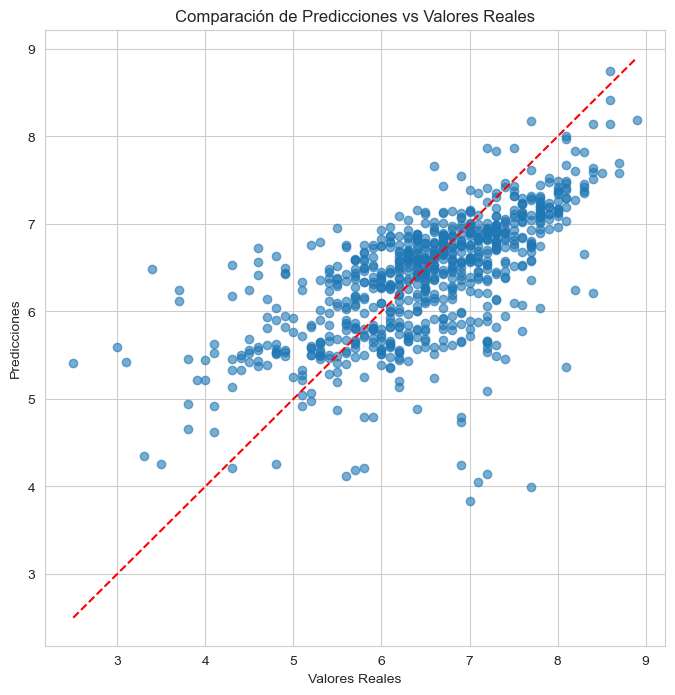

In [90]:
import matplotlib.pyplot as plt

# Predicciones finales
predictions = final_model.predict(X_val)

# Graficar
plt.figure(figsize=(8, 8))
plt.scatter(Y_val, predictions, alpha=0.6)
plt.plot([Y_val.min(), Y_val.max()], [Y_val.min(), Y_val.max()], '--r')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()
